# Piece-wise linear potential 2 - noise modelling

This is the second in a series of notebooks which will run importance sampling for the piece-wise linear potential. Familiarity with stochastic inflation and covariance matrices is assumed, see for example https://arxiv.org/pdf/2303.17375

In this notebook we show how the different noise curves can be found using the background trajectory. We use the Bessel matching approach to find the homogeneous noise.

Throughout natural units with $c = 8\pi M_{\rm PL} = \hbar =1$ are used.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import mystyle
plt.style.use(mystyle.paper_style)

# Need to make sure you have pyfpt installed
import pyfpt as fpt
from scipy.interpolate import CubicSpline
from scipy.integrate import odeint
from scipy.optimize import root
from scipy.integrate import quad
from timeit import default_timer as timer

from matplotlib.patches import Ellipse
from matplotlib.lines import Line2D
from matplotlib import colormaps
import matplotlib.animation as animation
from matplotlib.animation import PillowWriter
from matplotlib import colors
from matplotlib import colorbar

from mpmath import besselj as besselj_func
from mpmath import bessely as bessely_func
from mpmath import gamma as gamma_func

## Potential

In [2]:
def potential(phi):
    if phi > phi_star:
        return V_0 + A_plus*(phi - phi_star)
    elif phi <= phi_star:
        return V_0 + A_minus*(phi - phi_star)

    
def potential_dif(phi):
    if phi > phi_star:
        return A_plus
    elif phi <= phi_star:
        return A_minus

def potential_ddif(phi):
    return 0.

def V_prime_by_V(phi):
    if phi > phi_star:
        return A_plus/(V_0 + A_plus*(phi - phi_star))
    elif phi <= phi_star:
        return A_minus/(V_0 + A_minus*(phi - phi_star))

The parameters are shown such that the power spectrum peaks at $5 \times 10^{-3}$.

In [3]:
pi_num = np.pi

A_plus = 10**-14
A_minus = A_plus*(10**-3)
cmb_power_spectrum = 2*10**-9
V_0 = (12*cmb_power_spectrum*(pi_num*A_plus)**2)**(1/3)
H_0 = (V_0/3)**(1/2)
N_star = 26.
phi_star = 1.

### Loading in background

In [4]:
background_data = pd.read_csv("piece_wise_linear_dynamics_dynamics"+".csv", index_col=0)

N_values = np.array(background_data["N"])
phi_values = np.array(background_data["phi"])
phi_diff_values = np.array(background_data["phi_N_diff"])
hubble_param_values = np.array(background_data["H"])
epsilon1_values = np.array(background_data["epsilon1"])
epsilon2_values = np.array(background_data["epsilon2"])
nu_squared_values = np.array(background_data["nu_squared"])

N_end = N_values[-1]
phi_end_true = phi_values[-1]
a_in = 1

In [5]:
hubble_param_interpolation = CubicSpline(N_values, hubble_param_values)

aH_interpolation = CubicSpline(N_values, hubble_param_values*a_in*np.exp(N_values-N_star))

Updating the interpolation which are senstive to any errors to use the analytical versions

In [6]:
def comoving_time_func(N_interest, N_end):
    def comoving_time_integrand(N):
        aH = aH_interpolation(N)
        return 1/aH
    comoving_time_value, _ = quad(comoving_time_integrand, N_end, N_interest, limit=1000)
    return comoving_time_value

def analytical_epsilon_1(N_interest, N_end, N_transition, A_plus, A_minus):
    H = hubble_param_interpolation(N_interest)
    if N_interest<=N_transition:
        epsilon_1 = (A_plus**2)/(18*(H**4))
    elif N_interest>N_transition:
        Delta_A = A_minus - A_plus
        comoving_time = comoving_time_func(N_interest, N_end)
        k_transition = aH_interpolation(N_transition)
        epsilon_1 = ((Delta_A*(comoving_time*k_transition)**3 + A_minus)**2)/(18*(H**4))
    return epsilon_1

def analytical_epsilon_2(N_interest, N_end, N_transition, A_plus, A_minus):
    H = hubble_param_interpolation(N_interest)
    if N_interest<=N_transition:
        epsilon_2 = 0.
    elif N_interest>N_transition:
        Delta_A = A_minus - A_plus
        comoving_time = comoving_time_func(N_interest, N_end)
        k_transition = aH_interpolation(N_transition)
        epsilon_2 =\
            (-6*Delta_A*(comoving_time*k_transition)**3)/(Delta_A*(comoving_time*k_transition)**3 + A_minus)
    return epsilon_2

In [7]:
epsilon1_values = np.array([analytical_epsilon_1(N_values[i], N_end, N_star, A_plus, A_minus) for i in range(len(N_values))])
epsilon2_values = np.array([analytical_epsilon_2(N_values[i], N_end, N_star, A_plus, A_minus) for i in range(len(N_values))])

# interpolation
epsilon1_interpolation = CubicSpline(N_values, epsilon1_values)
epsilon2_interpolation = CubicSpline(N_values, epsilon2_values)

In [8]:
def nu_sqaured_func(N):
    epsilon2 = epsilon2_interpolation(N, 0)
    epsilon1 = epsilon1_interpolation(N, 0)
    epsilon2_derivative = epsilon2_interpolation(N, 1)
    return 9/4 - epsilon1 + (3/2)*epsilon2 - (1/2)*epsilon1*epsilon2 + (epsilon2**2)/4\
        + epsilon2_derivative/2

In [9]:
nu_squared_values = np.array([nu_sqaured_func(N_values[i]) for i in range(len(N_values))])

nu_squared_interpolation = CubicSpline(N_values, nu_squared_values)

## $\delta \phi_k$

In [10]:
def analytical_delta_phi(N_interest, N_end, N_transition, A_plus, A_minus, k):
    comoving_time = comoving_time_func(N_interest, N_end)
    k_0 = aH_interpolation(N_transition)
    a = a_interpolation(N_interest)
    H0 = hubble_param_interpolation(N_interest)
    aH = aH_interpolation(N_interest)
    Delta_A = A_minus - A_plus
    k_eta = k*comoving_time

    if N_interest>N_transition:
        alpha = 1. + complex(0, 1)*(3*Delta_A*k_0/(2*A_plus*k))*(1 + (k_0/k)**2)
        beta = complex(0, -1)*(3*Delta_A*k_0/(2*A_plus*k))*np.exp(complex(0, 2*k/k_0))*(complex(1, k_0/k)**2)
    else:
        alpha = 1.
        beta = 0.

    term1 = complex(1, k_eta)*np.exp(complex(0, -k_eta))
    term2 = complex(1, -k_eta)*np.exp(complex(0, k_eta))
    k_term = complex(0, H0/(2*k**3)**0.5)

    delta_phi = k_term*(alpha*term1 - beta*term2)
    return delta_phi

def analytical_delta_phi_N_derivative(N_interest, N_end, N_transition, A_plus, A_minus, k):
    comoving_time = comoving_time_func(N_interest, N_end)
    k_0 = aH_interpolation(N_transition)
    a = a_interpolation(N_interest)
    H0 = hubble_param_interpolation(N_interest)
    aH = aH_interpolation(N_interest)
    Delta_A = A_minus - A_plus
    k_eta = k*comoving_time

    if N_interest>N_transition:
        alpha = 1. + complex(0, 1)*(3*Delta_A*k_0/(2*A_plus*k))*(1 + (k_0/k)**2)
        beta = complex(0, -1)*(3*Delta_A*k_0/(2*A_plus*k))*np.exp(complex(0, 2*k/k_0))*(complex(1, k_0/k)**2)
    else:
        alpha = 1.
        beta = 0.

    term1_deriv = (k**2)*comoving_time*np.exp(complex(0, -k_eta))
    term2_deriv = (k**2)*comoving_time*np.exp(complex(0, k_eta))
    k_term = complex(0, H0/(2*k**3)**0.5)


    delta_phi_N_derivative = k_term*(alpha*term1_deriv - beta*term2_deriv)/aH
    return delta_phi_N_derivative

##  $\delta \phi_{\rm h}$

In [11]:
def analytical_delta_phi_homo(N_interest, N_end, N_transition, A_plus, A_minus, k, just_growing=False):
    comoving_time = comoving_time_func(N_interest, N_end)
    k_0 = aH_interpolation(N_transition)
    a = a_interpolation(N_interest)
    aH = aH_interpolation(N_interest)
    H = hubble_param_interpolation(N_interest)
    Delta_A = A_minus - A_plus

    if N_interest>N_transition:
        alpha = 1. + complex(0, 1)*(3*Delta_A*k_0/(2*A_plus*k))*(1 + (k_0/k)**2)
        beta = complex(0, -1)*(3*Delta_A*k_0/(2*A_plus*k))*np.exp(complex(0, 2*k/k_0))*(complex(1, k_0/k)**2)
    else:
        alpha = 1.
        beta = 0.
    prefactor = complex(0, H/(np.sqrt(2*k**3)))
    growing = alpha-beta
    if just_growing==True:
        decaying = 0.
    else:
        decaying = complex(0, -1/3)*(alpha + beta)*(k*comoving_time)**3

    return prefactor*(growing + decaying)

# My formula
def analytical_delta_phi_N_derivative_homo(N_interest, N_end, N_transition, A_plus, A_minus, k,
                                           just_growing=False):
    comoving_time = comoving_time_func(N_interest, N_end)
    k_0 = aH_interpolation(N_transition)
    a = a_interpolation(N_interest)
    aH = aH_interpolation(N_interest)
    H = hubble_param_interpolation(N_interest)
    Delta_A = A_minus - A_plus
    k_eta = k*comoving_time

    if N_interest>N_transition:
        alpha = 1. + complex(0, 1)*(3*Delta_A*k_0/(2*A_plus*k))*(1 + (k_0/k)**2)
        beta = complex(0, -1)*(3*Delta_A*k_0/(2*A_plus*k))*np.exp(complex(0, 2*k/k_0))*(complex(1, k_0/k)**2)
    else:
        alpha = 1.
        beta = 0.
        
    prefactor = complex(0, H/(np.sqrt(2*k**3)))
    growing = 0.
    if just_growing==True:
        decaying = 0.
    else:
        decaying = complex(0, -1)*(alpha + beta)*(k**3)*(comoving_time**2)
    # remember the factor of aH coming from d tau / dN
    return prefactor*(growing + decaying)/aH

# Noise modelling
We find the noise using the values of $\delta \phi$ for the noise analytically.

In [12]:
def find_cg_time(k, sigma, N_exit):
    def exit_time_func(N_cg_exit):
        return k - sigma*aH_interpolation(N_cg_exit)
    N_guess = N_exit + np.log(sigma**-1)
    sol_cg_time = root(exit_time_func, N_guess)
    N_cg_exit = sol_cg_time.x
    return float(N_cg_exit)

def find_exit_time(sigma, N_cg):
    def exit_time_func(N_exit):
        return sigma*aH_interpolation(N_cg)-aH_interpolation(N_exit)
    N_guess = N_cg + np.log(sigma)
    sol_exit_time = root(exit_time_func, N_guess)
    N_exit = sol_exit_time.x
    return float(N_exit)

In [13]:
def correlation_matrix(delta_phi, delta_phi_derivative, k_sigma, epsilon1):
    overall_amplitude = (1/(2*np.pi**2))*(1-epsilon1)*k_sigma**3

    phi_noise = overall_amplitude*np.abs(delta_phi)**2
    pi_noise = overall_amplitude*np.abs(delta_phi_derivative)**2
    # To make sure the complex conjugate can be calculated
    delta_phi_normed = delta_phi/np.abs(delta_phi)
    delta_phi_diff_conj_normed = np.conjugate(delta_phi_derivative)/np.abs(delta_phi)
    correlation = overall_amplitude*(delta_phi_normed*delta_phi_diff_conj_normed)
    # Need to then multiple by this overall amplitude
    correlation = correlation*np.abs(delta_phi)**2
    return np.array([phi_noise, correlation, np.conjugate(correlation), pi_noise])

Let us begin with direct coarse graining the noise. We can do this semi-analytically using the analytical mode solution. 

In [14]:
phi_post_transition = phi_values[N_values>N_star]
phi_deriv_post_transition = phi_values[N_values>N_star]
N_values_post_transition = N_values[N_values>N_star]

phi_in_post = phi_post_transition[0]
phi_deriv_in_post = phi_deriv_post_transition[0]

In [15]:
diff_const = H_0/(2*np.pi)

In [16]:
sigma = 0.01

N_scale_exit = N_values_post_transition[0]

# Rescale to this exit value
aH_interpolation = CubicSpline(N_values, hubble_param_values*a_in*np.exp(N_values-N_scale_exit))
k_in_scale = aH_interpolation(N_scale_exit)
k_transition = aH_interpolation(N_star)

# Need to reset the normalisation, as it changes in the loop below
aH_interpolation = CubicSpline(N_values, hubble_param_values*a_in*np.exp(N_values-N_scale_exit))
a_interpolation = CubicSpline(N_values, a_in*np.exp(N_values-N_scale_exit))

# Need to find when this scale left the coarse-graining scale, and the corresponding field values
N_cg_exit = find_cg_time(k_in_scale, sigma, N_scale_exit)

N_cg_values = np.arange(N_cg_exit, N_star+16, 0.001)

# Now find the noise for these values
covaraince_matrix_array = np.zeros((3, len(N_cg_values)))
for i in range(len(N_cg_values)):
    N_eval = N_cg_values[i]
    # Find when this mode left the horizon
    N_mode_exit = find_exit_time(sigma, N_eval)

    aH_interpolation = CubicSpline(N_values, hubble_param_values*a_in*np.exp(N_values-N_mode_exit))
    a_interpolation = CubicSpline(N_values, a_in*np.exp(N_values-N_mode_exit))

    k = aH_interpolation(N_mode_exit)

    delta_phi_at_sigma = analytical_delta_phi(N_eval, N_end, N_star, A_plus, A_minus, k)
    delta_phi_deriv_at_sigma =\
        analytical_delta_phi_N_derivative(N_eval, N_end, N_star, A_plus, A_minus, k)
    epsilon1 = epsilon1_interpolation(N_eval)
    covar_matrix = correlation_matrix(delta_phi_at_sigma, delta_phi_deriv_at_sigma, k, epsilon1)
    covaraince_matrix = np.array([[covar_matrix[0], covar_matrix[1]], [covar_matrix[2], covar_matrix[3]]])
    covaraince_matrix = covaraince_matrix.real
    covaraince_matrix_array[0, i] = covaraince_matrix[0, 0]
    covaraince_matrix_array[1, i] = covaraince_matrix[0, 1]
    covaraince_matrix_array[2, i] = covaraince_matrix[1, 1]

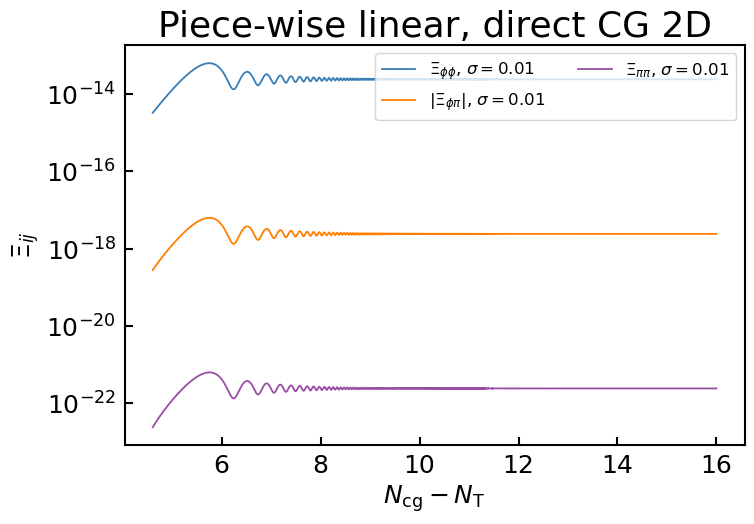

<Figure size 800x520 with 0 Axes>

In [17]:
plt.plot(N_cg_values-N_star, covaraince_matrix_array[0, :],
         label=r"$\Xi_{\phi \phi}$, $\sigma=$"+str(sigma))
plt.plot(N_cg_values-N_star, np.abs(covaraince_matrix_array[1, :]),
         label=r"$|\Xi_{\phi \pi}|$, $\sigma=$"+str(sigma))
plt.plot(N_cg_values-N_star, covaraince_matrix_array[2, :],
         label=r"$\Xi_{\pi \pi}$, $\sigma=$"+str(sigma))
plt.yscale("log")
plt.ylabel(r"$\Xi_{ij}$")
plt.xlabel(r"$N_{\rm cg}-N_{\rm T}$")
plt.legend(ncol=2, fontsize=12)
plt.title(r"Piece-wise linear, direct CG 2D")
plt.show()
plt.clf()

This is behaving exactly as expected. 

If one is interesting in using this approach to find the noise, then you need to find the noise matrix, $S = \Xi^2$, from the above. Let's do this using eigen decomposition.

In [18]:
sigma = 0.01

N_scale_exit = N_values_post_transition[0]

# Rescale to this exit value
aH_interpolation = CubicSpline(N_values, hubble_param_values*a_in*np.exp(N_values-N_scale_exit))
k_in_scale = aH_interpolation(N_scale_exit)
k_transition = aH_interpolation(N_star)

# Need to reset the normalisation, as it changes in the loop below
aH_interpolation = CubicSpline(N_values, hubble_param_values*a_in*np.exp(N_values-N_scale_exit))
a_interpolation = CubicSpline(N_values, a_in*np.exp(N_values-N_scale_exit))

# Need to find when this scale left the coarse-graining scale, and the corresponding field values
N_cg_exit = find_cg_time(k_in_scale, sigma, N_scale_exit)

N_cg_values = np.arange(N_cg_exit, N_star+16, 0.001)

# Now find the noise for these values
noise_matrix_array = np.zeros((3, len(N_cg_values)))
for i in range(len(N_cg_values)):
    N_eval = N_cg_values[i]
    # Find when this mode left the horizon
    N_mode_exit = find_exit_time(sigma, N_eval)

    aH_interpolation = CubicSpline(N_values, hubble_param_values*a_in*np.exp(N_values-N_mode_exit))
    a_interpolation = CubicSpline(N_values, a_in*np.exp(N_values-N_mode_exit))

    k = aH_interpolation(N_mode_exit)

    delta_phi_at_sigma = analytical_delta_phi(N_eval, N_end, N_star, A_plus, A_minus, k)
    delta_phi_deriv_at_sigma =\
        analytical_delta_phi_N_derivative(N_eval, N_end, N_star, A_plus, A_minus, k)
    epsilon1 = epsilon1_interpolation(N_eval)
    covar_matrix = correlation_matrix(delta_phi_at_sigma, delta_phi_deriv_at_sigma, k, epsilon1)
    covaraince_matrix = np.array([[covar_matrix[0], covar_matrix[1]], [covar_matrix[2], covar_matrix[3]]])
    # Normalise to hopefully make the square root more accurate
    covaraince_matrix = covaraince_matrix/(diff_const**2)
    covaraince_matrix = covaraince_matrix.real
    eigenvalues, eigenvectors = np.linalg.eig(covaraince_matrix)
    # Find the inverse eigenvector for diagonalisation
    eigenvectors_inverse = np.linalg.inv(eigenvectors)
    # Now find the square root of the eigen value matrix
    Lambda_root = np.asmatrix([[eigenvalues[0]**0.5, 0], [0, eigenvalues[1]**0.5]])
    noise_matrix = eigenvectors*Lambda_root*eigenvectors_inverse
    # As this is symmetric, let's convert it back into its usual form
    noise_matrix_array[0, i] = noise_matrix[0, 0]
    noise_matrix_array[1, i] = noise_matrix[0, 1]
    noise_matrix_array[2, i] = noise_matrix[1, 1]

# Rescale at the end
noise_matrix_array = noise_matrix_array*(diff_const)

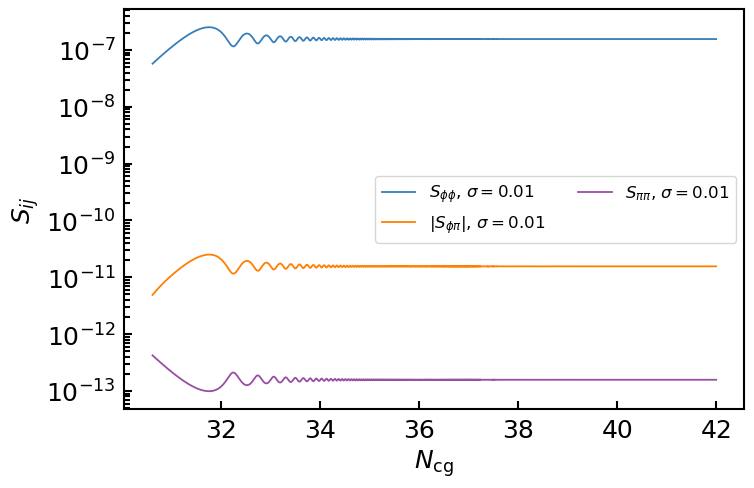

<Figure size 800x520 with 0 Axes>

In [19]:
plt.plot(N_cg_values, noise_matrix_array[0, :],
         label=r"$S_{\phi \phi}$, $\sigma=$"+str(sigma))
plt.plot(N_cg_values, np.abs(noise_matrix_array[1, :]),
         label=r"$|S_{\phi \pi}|$, $\sigma=$"+str(sigma))
plt.plot(N_cg_values, noise_matrix_array[2, :],
         label=r"$S_{\pi \pi}$, $\sigma=$"+str(sigma))
plt.yscale("log")
plt.ylabel(r"$S_{ij}$")
plt.xlabel(r"$N_{\rm cg}$")
plt.legend(ncol=2, fontsize=12)
plt.show()
plt.clf()

The above curves are the standard approach for finding the noise.

## Ellipse
Now let us show behaviour of the homogeneous mode. Specifically its super-Hubble squeezing after the transition.

In [20]:
color = ['#377eb8', '#ff7f00', '#984ea3','#4daf4a', '#a65628', '#f781bf','#999999', '#e41a1c', '#dede00']

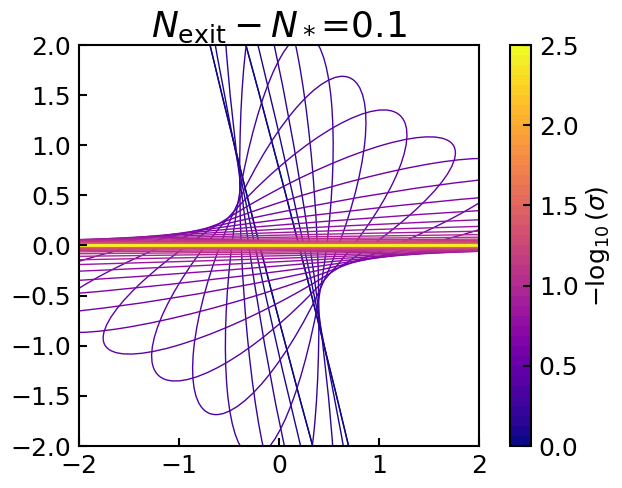

<Figure size 800x520 with 0 Axes>

In [21]:
cmap = colormaps['plasma']
frames = 40
sigma_values = 10**np.linspace(-2.5, 0, frames)
sigma_values = np.flip(sigma_values)
colors_plasma = cmap(np.linspace(0, 1, frames))
cmap_color_bar = plt.get_cmap('plasma', frames) 
norm_colors = colors.Normalize(vmin=-np.log10(sigma_values[0]), vmax=-np.log10(sigma_values[-1]))

N_scale_exit = N_star + 0.1

# Rescale to this exit value
aH_interpolation = CubicSpline(N_values, hubble_param_values*a_in*np.exp(N_values-N_scale_exit))
a_interpolation = CubicSpline(N_values, a_in*np.exp(N_values-N_scale_exit))
k_in_scale = aH_interpolation(N_scale_exit)
k_transition = aH_interpolation(N_star)


fig, ax = plt.subplots(1)
ax.set_aspect('equal')

def update(frame):
    sigma = sigma_values[frame]

    N_eval = find_cg_time(k_in_scale, sigma, N_scale_exit)

    k = aH_interpolation(N_scale_exit)

    delta_phi_at_sigma = analytical_delta_phi_homo(N_eval, N_end, N_star, A_plus, A_minus, k)
    delta_phi_deriv_at_sigma =\
        analytical_delta_phi_N_derivative_homo(N_eval, N_end, N_star, A_plus, A_minus, k)
    epsilon1 = epsilon1_interpolation(N_eval)

    covar_matrix = correlation_matrix(delta_phi_at_sigma, delta_phi_deriv_at_sigma, k, epsilon1)
    # Normalise to hopefully keep everything to reasonable numbers
    covaraince_matrix = np.array([[covar_matrix[0], covar_matrix[1]], [covar_matrix[2], covar_matrix[3]]])
    covaraince_matrix = covaraince_matrix/(diff_const**2)
    covaraince_matrix = covaraince_matrix.real
    # Using Kazuya's code
    S = covaraince_matrix
    # Using Kazuya's code
    S = covaraince_matrix
    su2 = ((S[0, 0] + S[1, 1]) + np.sqrt((S[0, 0] - S[1, 1])**2 + 4*S[0, 1]**2)) / 2
    sv2 = ((S[0, 0] + S[1, 1]) - np.sqrt((S[0, 0] - S[1, 1])**2 + 4*S[0, 1]**2)) / 2
    slope1 = (su2 - S[0, 0]) / S[0, 1]
    theta = np.arctan(slope1) * 180.0 / np.pi
    m = np.array([0, 0])
    a = np.sqrt(su2)
    b = np.sqrt(sv2)
    normalisation = (a*b)**0.5
    a = a/normalisation
    b = b/normalisation

    return ax.add_patch(Ellipse(m, 2*a, 2*b, angle=theta, color=colors_plasma[frame], fill=False, zorder=0))


sm = plt.cm.ScalarMappable(cmap=cmap_color_bar, norm=norm_colors) 
sm.set_array([])
plt.colorbar(sm, ax=ax, label=r"$- \log_{10} (\sigma)$") 

# Drawing animation
ani = animation.FuncAnimation(fig=fig, func=update, frames=40, interval=30)
ax.set_title(r"$N_{\rm exit} - N_*$="+str(round(N_scale_exit-N_star, 3)))
plt.xlim(-2, 2)
plt.ylim(-2, 2)
ani.save("elipse_animation_N_exit_relative_"+str(round(N_scale_exit-N_star, 3))+".gif", dpi=300,
         writer=PillowWriter(fps=5))
plt.show()
plt.clf()

As the squeezing is related to the eccentricity of the ellipse, this clearly shows the super-Hubble squeezing of the mode. A .gif file was also made, go check it out!

## Bessel matching
While for this analytical model we know what the [homogeneous mode is doing](https://arxiv.org/pdf/2311.03281), in general we don't for realistic models. Therefore we use this model as a test case for the Bessel matching approach, although here it is not needed.

In [22]:
def besselj_derivative_func(comoving_time, nu, k):
    J_plus_1 = besselj_func(nu+1, -k*comoving_time)
    J_minus_1 = besselj_func(nu-1, -k*comoving_time)
    return (k/2)*(J_plus_1 - J_minus_1)

def bessely_derivative_func(comoving_time, nu, k):
    Y_plus_1 = bessely_func(nu+1, -k*comoving_time)
    Y_minus_1 = bessely_func(nu-1, -k*comoving_time)
    return (k/2)*(Y_plus_1 - Y_minus_1)

def R_matching_to_Bessels(R, R_diff, N_interest, N_end, nu, k):
    comoving_time = comoving_time_func(N_interest, N_end)
    epsilon1 = epsilon1_interpolation(N_interest)
    epsilon2 = epsilon2_interpolation(N_interest)
    a = a_interpolation(N_interest)
    aH = aH_interpolation(N_interest)
    z = (2*epsilon1*a**2)**0.5
    z_prime_z = aH*(1 + 0.5*epsilon2)
    extra_term = -(z_prime_z + 1/(-2*comoving_time))
    besselj_value = besselj_func(nu, -k*comoving_time)
    bessely_value = bessely_func(nu, -k*comoving_time)
    besselj_diff_value = besselj_derivative_func(comoving_time, nu, k)
    bessely_diff_value = bessely_derivative_func(comoving_time, nu, k)
    # Need to convert to comoving time
    R_prime = aH*R_diff
    # Factor to change to R
    prefactor = ((-comoving_time)**0.5)/z
    # Now the different pre-factors needed to find A and B
    c = prefactor*besselj_value
    d = prefactor*bessely_value
    e = prefactor*(extra_term*besselj_value + besselj_diff_value)
    f = prefactor*(extra_term*bessely_value + bessely_diff_value)
    # Now just need to solve standard system of simultanious equations
    B = (c*R_prime - e*R)/(c*f - d*e)
    A = (R - B*d)/c
    return complex(A), complex(B)

def homogeneous_Bessel_delta_phi(N_interest, N_end, nu, k, A, B, just_growing=False):
    comoving_time = comoving_time_func(N_interest, N_end)
    k_comoving_time = -k*comoving_time
    a = a_interpolation(N_interest)
    aH = aH_interpolation(N_interest)
    term1 = (A/gamma_func(nu+1) - B*gamma_func(-nu)*np.cos(nu*np.pi)/np.pi)*(0.5*k_comoving_time)**nu
    term2 = (-B*gamma_func(nu)/np.pi)*(0.5*k_comoving_time)**-nu
    if just_growing==True:
        sasaki_mukanov = (term2)*(-comoving_time)**0.5
    else:
        sasaki_mukanov = (term1 + term2)*(-comoving_time)**0.5
    delta_phi = sasaki_mukanov/a
    return complex(delta_phi)

def homogeneous_Bessel_delta_phi_N_derivative(N_interest, N_end, nu, k, A, B, just_growing=False):
    comoving_time = comoving_time_func(N_interest, N_end)
    k_comoving_time = -k*comoving_time
    a = a_interpolation(N_interest)
    aH = aH_interpolation(N_interest)
    extra_term = (-aH + 0.5/comoving_time)
    d = (-B*gamma_func(nu)/np.pi)
    if just_growing==True:
        # this is the coefficent of the decaying mde, so if we set it to zero we are neglecting it
        c = 0.
    else:
        c = (A/gamma_func(nu+1) - B*gamma_func(-nu)*np.cos(nu*np.pi)/np.pi)
    # This includes the 1/aH from changing to an N derivative, dN = aH d comoving time
    prefactor = ((-comoving_time)**0.5)/(aH*a)
    term_1 = extra_term*(c*(0.5*k_comoving_time)**(nu) + d*(0.5*k_comoving_time)**(-nu))
    term_2 = 0.5*(nu*k)*(-c*(0.5*k_comoving_time)**(nu-1) + d*(0.5*k_comoving_time)**(-nu - 1))
    delta_phi_homo_derivative = prefactor*(term_1 + term_2)
    return complex(delta_phi_homo_derivative)

In [23]:
def R_from_delta_phi(N_interest, delta_phi, delta_phi_N_derivative):
    epsilon1 = epsilon1_interpolation(N_interest)
    # Remember previously there was a mistake here
    return delta_phi/(2*epsilon1)**0.5

def R_N_derivative_from_delta_phi(N_interest, delta_phi, delta_phi_N_derivative):
    epsilon1 = epsilon1_interpolation(N_interest)
    epsilon2 = epsilon2_interpolation(N_interest)
    return (delta_phi_N_derivative - 0.5*epsilon2*delta_phi)/(2*epsilon1)**0.5

We should also evalute over the range and times for the simulations. The range used is over a scale of 1000 from the transition.

In [24]:
aH_interpolation = CubicSpline(N_values, hubble_param_values*a_in*np.exp(N_values-N_star))
a_interpolation = CubicSpline(N_values, a_in*np.exp(N_values-N_star))

N_sim_end_estimate = N_star + np.log(10**3)

sim_range_logic = (N_values>N_star+0.05) & (N_values<N_sim_end_estimate)

N_values_sim_range = N_values[sim_range_logic]
phi_values_sim_range = phi_values[sim_range_logic]
phi_diff_values_sim_range = phi_diff_values[sim_range_logic]


N_sim_start = N_values_sim_range[0]
phi_sim_start = phi_values_sim_range[0]
phi_sim_diff_start = phi_diff_values_sim_range[0]

N_sim_end = N_values_sim_range[-1]
phi_sim_end = phi_values_sim_range[-1]
phi_sim_diff_end = phi_diff_values_sim_range[-1]

We can use the slow-roll expectation for the standard deviation to estimate the time step needed

In [25]:
std = fpt.analytics.variance_efolds(potential, potential_dif, potential_ddif, phi_sim_start, phi_sim_end)**0.5
dN = std/2000
print(dN)

0.00038251633703158353


In [26]:
sigma = 0.01

N_exit_values = np.arange(N_sim_start, N_sim_end, dN)
N_cg_values = np.zeros(len(N_exit_values))

# Now find the noise for these values
noise_matrix_array = np.zeros((3, len(N_exit_values)))
for i in range(len(N_exit_values)):
    N_mode_exit = N_exit_values[i]

    aH_interpolation = CubicSpline(N_values, hubble_param_values*a_in*np.exp(N_values-N_mode_exit))
    a_interpolation = CubicSpline(N_values, a_in*np.exp(N_values-N_mode_exit))

    k = aH_interpolation(N_mode_exit)

    # Find when this mode left the coarse-graining scale
    N_eval = find_cg_time(k, sigma, N_mode_exit)
    N_cg_values[i] = N_eval

    nu = complex(nu_squared_interpolation(N_eval), 0)**0.5
    # First find the full version

    delta_phi_at_sigma = analytical_delta_phi(N_eval, N_end, N_star, A_plus, A_minus, k)
    delta_phi_deriv_at_sigma =\
        analytical_delta_phi_N_derivative(N_eval, N_end, N_star, A_plus, A_minus, k)

    # Then find the R from this
    R_at_sigma = R_from_delta_phi(N_eval, delta_phi_at_sigma, delta_phi_deriv_at_sigma)
    R_diff_at_sigma = R_N_derivative_from_delta_phi(N_eval, delta_phi_at_sigma, delta_phi_deriv_at_sigma)

    # We use these values to find the homogeneous behaviour
    A, B = R_matching_to_Bessels(R_at_sigma, R_diff_at_sigma, N_eval, N_end, nu, k)
    # Now we can find delta phi from these values
    delta_phi_at_sigma =\
        homogeneous_Bessel_delta_phi(N_eval, N_end, nu, k, A, B)
    delta_phi_deriv_at_sigma =\
        homogeneous_Bessel_delta_phi_N_derivative(N_eval, N_end, nu, k, A, B)
    tan_theta = np.real(delta_phi_deriv_at_sigma/delta_phi_at_sigma)

    epsilon1 = epsilon1_interpolation(N_eval)
    covar_matrix = correlation_matrix(delta_phi_at_sigma, delta_phi_deriv_at_sigma, k, epsilon1)
    covaraince_matrix = np.array([[covar_matrix[0], covar_matrix[1]], [covar_matrix[2], covar_matrix[3]]])
    # Rescale to make finding the square root more accurate
    covaraince_matrix = covaraince_matrix/(diff_const**2)
    covaraince_matrix = covaraince_matrix.real
    eigenvalues, eigenvectors = np.linalg.eig(covaraince_matrix)
    # Find the inverse eigenvector for diagonalisation
    eigenvectors_inverse = np.linalg.inv(eigenvectors)
    # Now find the square root of the eigen value matrix
    Lambda_root = np.asmatrix([[eigenvalues[0]**0.5, 0], [0, eigenvalues[1]**0.5]])
    noise_matrix = eigenvectors*Lambda_root*eigenvectors_inverse
    noise_matrix_array[0, i] = noise_matrix[0, 0]
    noise_matrix_array[1, i] = noise_matrix[0, 1]
    noise_matrix_array[2, i] = noise_matrix[1, 1]

# Rescale at the end
noise_matrix_array = noise_matrix_array*(diff_const)

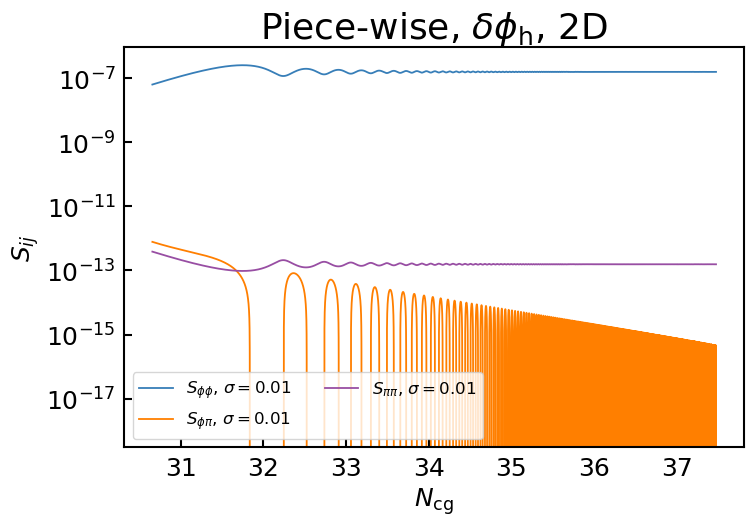

<Figure size 800x520 with 0 Axes>

In [27]:
# Now we can run the simulation
plt.plot(N_cg_values, noise_matrix_array[0, :],
         label=r"$S_{\phi \phi}$, $\sigma=$"+str(sigma))
plt.plot(N_cg_values, noise_matrix_array[1, :],
         label=r"$S_{\phi \pi}$, $\sigma=$"+str(sigma))
plt.plot(N_cg_values, noise_matrix_array[2, :],
         label=r"$S_{\pi \pi}$, $\sigma=$"+str(sigma))
plt.yscale("log")
plt.ylabel(r"$S_{ij}$")
plt.xlabel(r"$N_{\rm cg}$")
plt.legend(ncol=2, fontsize=12)
plt.title(r"Piece-wise, $\delta \phi_{\rm h}$, 2D")
plt.show()
plt.clf()

While the $\pi$ noise is the same, the other two curves are quite different to the direct coarse-graining curves.

Now let's save these noise curves for later use.

In [28]:
data_dict = {}
data_dict["N"] = N_cg_values
data_dict["phi-phi noise"] = noise_matrix_array[0, :]
data_dict["phi-pi noise"] = noise_matrix_array[1, :]
data_dict["pi-pi noise"] = noise_matrix_array[2, :]

data_pandas = pd.DataFrame(data_dict)

data_pandas.to_csv("piece_wise_linear_noise_curves_Bessel_matched_sigma_"+str(sigma)+"_2D.csv")

In [29]:
len(N_cg_values)*dN

6.821413838284229

### 1D noise
We can also find a 1D noise if the decaying mode is dropped. Let's find this for $\sigma=0.01$ initially.

The covariance matrix for 1D noise does not have a squareroot. So instead we just find the noise from the first element and the angle made by the noise in phase space

In [30]:
sigma = 0.01

N_exit_values = np.arange(N_sim_start, N_sim_end, dN)
N_cg_values = np.zeros(len(N_exit_values))

# Now find the noise for these values
noise_matrix_array = np.zeros((2, len(N_exit_values)))
for i in range(len(N_exit_values)):
    N_mode_exit = N_exit_values[i]

    aH_interpolation = CubicSpline(N_values, hubble_param_values*a_in*np.exp(N_values-N_mode_exit))
    a_interpolation = CubicSpline(N_values, a_in*np.exp(N_values-N_mode_exit))

    k = aH_interpolation(N_mode_exit)

    # Find when this mode left the coarse-graining scale
    N_eval = find_cg_time(k, sigma, N_mode_exit)
    N_cg_values[i] = N_eval

    nu = complex(nu_squared_interpolation(N_eval), 0)**0.5
    # First find the full version

    delta_phi_at_sigma = analytical_delta_phi(N_eval, N_end, N_star, A_plus, A_minus, k)
    delta_phi_deriv_at_sigma =\
        analytical_delta_phi_N_derivative(N_eval, N_end, N_star, A_plus, A_minus, k)

    # Then find the R from this
    R_at_sigma = R_from_delta_phi(N_eval, delta_phi_at_sigma, delta_phi_deriv_at_sigma)
    R_diff_at_sigma = R_N_derivative_from_delta_phi(N_eval, delta_phi_at_sigma, delta_phi_deriv_at_sigma)

    # We use these values to find the homogeneous behaviour
    A, B = R_matching_to_Bessels(R_at_sigma, R_diff_at_sigma, N_eval, N_end, nu, k)
    # Now we can find delta phi from these values
    delta_phi_at_sigma =\
        homogeneous_Bessel_delta_phi(N_eval, N_end, nu, k, A, B, just_growing=True)
    delta_phi_deriv_at_sigma =\
        homogeneous_Bessel_delta_phi_N_derivative(N_eval, N_end, nu, k, A, B, just_growing=True)
    tan_theta = np.real(delta_phi_deriv_at_sigma/delta_phi_at_sigma)

    epsilon1 = epsilon1_interpolation(N_eval)
    covar_matrix = correlation_matrix(delta_phi_at_sigma, delta_phi_deriv_at_sigma, k, epsilon1)
    covaraince_matrix = np.array([[covar_matrix[0], covar_matrix[1]], [covar_matrix[2], covar_matrix[3]]])
    covar_matrix = covar_matrix.real
    # The phi noise is just the element square root, then pi noise is just this times the ratio
    noise_matrix_array[0, i] = covar_matrix[0]**0.5
    noise_matrix_array[1, i] = tan_theta*covar_matrix[0]**0.5

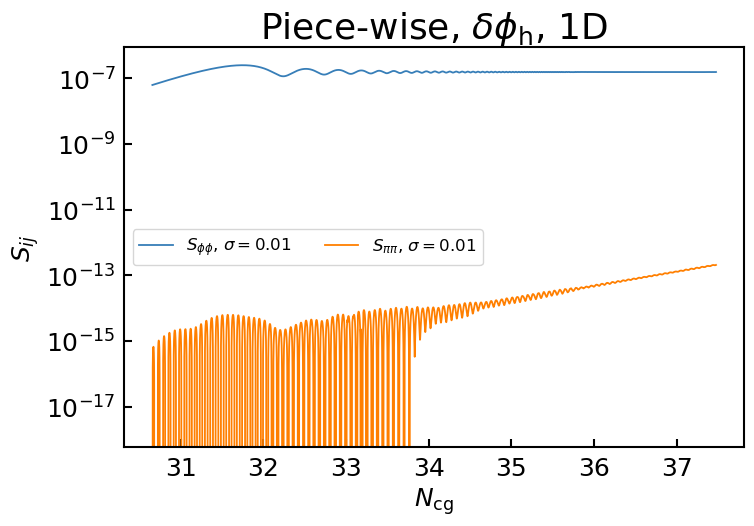

<Figure size 800x520 with 0 Axes>

In [31]:
plt.plot(N_cg_values, noise_matrix_array[0, :],
         label=r"$S_{\phi \phi}$, $\sigma=$"+str(sigma))
plt.plot(N_cg_values, noise_matrix_array[1, :],
         label=r"$S_{\pi \pi}$, $\sigma=$"+str(sigma))
plt.yscale("log")
plt.ylabel(r"$S_{ij}$")
plt.xlabel(r"$N_{\rm cg}$")
plt.legend(ncol=2, fontsize=12)
plt.title(r"Piece-wise, $\delta \phi_{\rm h}$, 1D")
plt.show()
plt.clf()

We can also find the noise near Hubble exit.

In [32]:
sigma = 1.

N_exit_values = np.arange(N_sim_start, N_sim_end, dN)
N_cg_values = np.zeros(len(N_exit_values))

# Now find the noise for these values
noise_matrix_array = np.zeros((2, len(N_exit_values)))
for i in range(len(N_exit_values)):
    N_mode_exit = N_exit_values[i]

    aH_interpolation = CubicSpline(N_values, hubble_param_values*a_in*np.exp(N_values-N_mode_exit))
    a_interpolation = CubicSpline(N_values, a_in*np.exp(N_values-N_mode_exit))

    k = aH_interpolation(N_mode_exit)

    # Find when this mode left the coarse-graining scale
    N_eval = find_cg_time(k, sigma, N_mode_exit)
    N_cg_values[i] = N_eval

    nu = complex(nu_squared_interpolation(N_eval), 0)**0.5
    # First find the full version

    delta_phi_at_sigma = analytical_delta_phi(N_eval, N_end, N_star, A_plus, A_minus, k)
    delta_phi_deriv_at_sigma =\
        analytical_delta_phi_N_derivative(N_eval, N_end, N_star, A_plus, A_minus, k)

    # Then find the R from this
    R_at_sigma = R_from_delta_phi(N_eval, delta_phi_at_sigma, delta_phi_deriv_at_sigma)
    R_diff_at_sigma = R_N_derivative_from_delta_phi(N_eval, delta_phi_at_sigma, delta_phi_deriv_at_sigma)

    # We use these values to find the homogeneous behaviour
    A, B = R_matching_to_Bessels(R_at_sigma, R_diff_at_sigma, N_eval, N_end, nu, k)
    # Now we can find delta phi from these values
    delta_phi_at_sigma =\
        homogeneous_Bessel_delta_phi(N_eval, N_end, nu, k, A, B, just_growing=True)
    delta_phi_deriv_at_sigma =\
        homogeneous_Bessel_delta_phi_N_derivative(N_eval, N_end, nu, k, A, B, just_growing=True)
    tan_theta = np.real(delta_phi_deriv_at_sigma/delta_phi_at_sigma)

    epsilon1 = epsilon1_interpolation(N_eval)
    covar_matrix = correlation_matrix(delta_phi_at_sigma, delta_phi_deriv_at_sigma, k, epsilon1)
    covaraince_matrix = np.array([[covar_matrix[0], covar_matrix[1]], [covar_matrix[2], covar_matrix[3]]])
    covar_matrix = covar_matrix.real
    # The phi noise is just the element square root, then pi noise is just this times the ratio
    noise_matrix_array[0, i] = covar_matrix[0]**0.5
    noise_matrix_array[1, i] = tan_theta*covar_matrix[0]**0.5

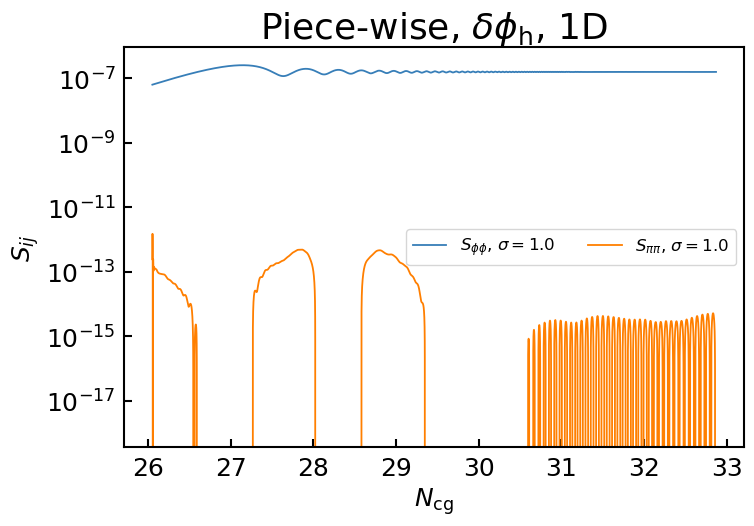

<Figure size 800x520 with 0 Axes>

In [33]:
plt.plot(N_cg_values, noise_matrix_array[0, :],
         label=r"$S_{\phi \phi}$, $\sigma=$"+str(sigma))
plt.plot(N_cg_values, noise_matrix_array[1, :],
         label=r"$S_{\pi \pi}$, $\sigma=$"+str(sigma))
plt.yscale("log")
plt.ylabel(r"$S_{ij}$")
plt.xlabel(r"$N_{\rm cg}$")
plt.legend(ncol=2, fontsize=12)
plt.title(r"Piece-wise, $\delta \phi_{\rm h}$, 1D")
plt.show()
plt.clf()

In both cases, the $\pi$ noise is strongly sub-dominate, as expected when the decaying mode is dropped and the growing mode is just a constant.

We can do the same for all of the different $\sigma$ values, and save the different noise curves as we go.

In [34]:
sigma_values = np.array([1.0, 0.5, 0.1, 0.01])

for sigma_index in range(len(sigma_values)):
    sigma = sigma_values[sigma_index]
    N_exit_values = np.arange(N_sim_start, N_sim_end, dN)
    N_cg_values = np.zeros(len(N_exit_values))

    # Now find the noise for these values
    noise_matrix_array = np.zeros((2, len(N_exit_values)))
    for i in range(len(N_exit_values)):
        N_mode_exit = N_exit_values[i]

        aH_interpolation = CubicSpline(N_values, hubble_param_values*a_in*np.exp(N_values-N_mode_exit))
        a_interpolation = CubicSpline(N_values, a_in*np.exp(N_values-N_mode_exit))

        k = aH_interpolation(N_mode_exit)

        # Find when this mode left the coarse-graining scale
        N_eval = find_cg_time(k, sigma, N_mode_exit)
        N_cg_values[i] = N_eval

        nu = complex(nu_squared_interpolation(N_eval), 0)**0.5
        # First find the full version

        delta_phi_at_sigma = analytical_delta_phi(N_eval, N_end, N_star, A_plus, A_minus, k)
        delta_phi_deriv_at_sigma =\
            analytical_delta_phi_N_derivative(N_eval, N_end, N_star, A_plus, A_minus, k)

        # Then find the R from this
        R_at_sigma = R_from_delta_phi(N_eval, delta_phi_at_sigma, delta_phi_deriv_at_sigma)
        R_diff_at_sigma = R_N_derivative_from_delta_phi(N_eval, delta_phi_at_sigma, delta_phi_deriv_at_sigma)

        # We use these values to find the homogeneous behaviour
        A, B = R_matching_to_Bessels(R_at_sigma, R_diff_at_sigma, N_eval, N_end, nu, k)
        # Now we can find delta phi from these values
        delta_phi_at_sigma =\
            homogeneous_Bessel_delta_phi(N_eval, N_end, nu, k, A, B, just_growing=True)
        delta_phi_deriv_at_sigma =\
            homogeneous_Bessel_delta_phi_N_derivative(N_eval, N_end, nu, k, A, B, just_growing=True)
        tan_theta = np.real(delta_phi_deriv_at_sigma/delta_phi_at_sigma)

        epsilon1 = epsilon1_interpolation(N_eval)
        covar_matrix = correlation_matrix(delta_phi_at_sigma, delta_phi_deriv_at_sigma, k, epsilon1)
        covaraince_matrix = np.array([[covar_matrix[0], covar_matrix[1]], [covar_matrix[2], covar_matrix[3]]])
        covar_matrix = covar_matrix.real
        # The phi noise is just the element square root, then pi noise is just this times the ratio
        noise_matrix_array[0, i] = covar_matrix[0]**0.5
        noise_matrix_array[1, i] = tan_theta*covar_matrix[0]**0.5
    data_dict = {}
    data_dict["N"] = N_cg_values
    data_dict["phi-phi noise"] = noise_matrix_array[0, :]
    data_dict["pi-pi noise"] = noise_matrix_array[1, :]

    data_pandas = pd.DataFrame(data_dict)

    data_pandas.to_csv("piece_wise_linear_noise_curves_Bessel_matched_sigma_"+str(sigma)+"_1D.csv")